In [1]:
import json
import pandas as pd
import itertools
import csv
import pickle
import nltk
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score



In [2]:
plt.style.use('seaborn')

In [3]:
pkl_path = '/Users/xzhou/github/project_files/amazon/amazon_alexa_reviews.pkl'

with open(pkl_path, 'rb') as pkl_file:
    df = pd.read_pickle(pkl_file)

df.head()

rating       date                                             review  \
2       4 2018-07-31  Sometimes while playing a game, you can answer...   
3       5 2018-07-31  I have had a lot of fun with this thing. My 4 ...   
5       5 2018-07-31  I received the echo as a gift. I needed anothe...   
6       3 2018-07-31  Without having a cellphone, I cannot use many ...   
7       5 2018-07-31  I think this is the 5th one I've purchased. I'...   

                                      review_by_word  word_count  
2  [Sometimes, while, playing, a, game, ,, you, c...          41  
3  [I, have, had, a, lot, of, fun, with, this, th...          38  
5  [I, received, the, echo, as, a, gift, ., I, ne...          38  
6  [Without, having, a, cellphone, ,, I, can, not...          84  
7  [I, think, this, is, the, 5th, one, I, 've, pu...          45

In [4]:
df.shape

(7248, 5)

In [5]:
# Assign sentiment:

def assign_sentiment(x):
    sentiment = ''
    if x < 3:
        sentiment = -1
    elif x == 3:
        sentiment = 0
    else:
        sentiment =1
    return sentiment

In [6]:
df['sentiment'] = df['rating'].apply(lambda x: assign_sentiment(x))

In [7]:
X = df['review']

In [8]:
y = df['sentiment']

In [244]:
class KMeansEngine:
    def __init__(self, data, vectorizer_name, max_df_, min_df_, vector_max_features_):
        """
        The function supports tfidf and count vecotrizer only. Please select 'tiidf' or 'count'
        for vecotrizer. Provided with desired arguments, it will create a vector, 
        and vectorize data
        """
        self.vector_max_features = vector_max_features_
        self.vectorizer(vectorizer_name, max_df_, min_df_)
        self.vectorize_data(data)
            
    
    def vectorizer(self, vectorizer_name, max_df_, min_df_):
        """
        The function supports tfidf and count vecotrizer only. Provided with desired
        argument, return a vector
        """
        if vectorizer_name.lower() == 'tfidf':
            self.vector = TfidfVectorizer(ngram_range=(1,2),
                               stop_words='english',
                               token_pattern="\\b[a-z][a-z]+\\b",
                               lowercase=True,
                               max_df=max_df_,
                               min_df=min_df_,
                               max_features=self.vector_max_features)
            return self.vector
        
        elif vectorizer_name.lower() == 'count':
            self.vector = CountVectorizer(ngram_range=(1,2),
                               stop_words='english',
                               token_pattern="\\b[a-z][a-z]+\\b",
                               lowercase=True,
                               max_df=max_df_,
                               min_df=min_df_,
                               max_features=self.vector_max_features)
            return self.vector
        
        else:
            return 'error'
        
    
    def vectorize_data(self, data):
        """
        Return vectorized data using specificed vector
        """
        self.vectorized_data = self.vector.fit_transform(data)       
        return self.vectorized_data
    
    def dimension_reduction (self, reduction_method, reduction_max_features_):
        """
        Support svd and nmf only.
        """
        if reduction_method.lower() == 'svd':
            lsa = TruncatedSVD(n_components=reduction_max_features_)
            self.reduced_data = lsa.fit_transform(self.vectorized_data)
            
        elif reduction_method.lower() == 'nmf':
            nmf = NMF(n_components=reduction_max_features_)
            self.reduced_data = nmf.fit_transform(self.vectorized_data)
            
        return self.reduced_data
            
    
    def KMeans_iterations(self, max_num_clusters):
        """
        Perform Kmeans fit from 2 to maximum number of clusters specified,
        return sil score and SSE for each number of cluster 
        """
        self.Sil_coefs = []
        self.SSEs = []
        self.k_clusters = range(2, max_num_clusters+1)

        for k in range(2, max_num_clusters+1):
            km = KMeans(n_clusters=k, random_state=99, n_jobs=-1)
            km.fit(self.reduced_data)
            labels = km.labels_
            self.Sil_coefs.append(silhouette_score(self.reduced_data, labels, metric='euclidean'))
            self.SSEs.append(km.inertia_) 
  
            
    def draw_KMeans_plot(self):
        """
        Plot two subplots for Sil_coefficients, and SSEs
        """

        fig, ax = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)

        ax[0].plot(self.k_clusters, self.Sil_coefs)
        ax[0].set_xlabel('number of clusters')
        ax[0].set_ylabel('Silhouette coefficient')

        ax[1].plot(self.k_clusters, self.SSEs)
        ax[1].set_xlabel('number of clusters')
        ax[1].set_ylabel('SSE')
        
    def KMeans_model(self, num_clusters):
        """
        This is to build one KMeans model with given argument
        """
        km = KMeans(n_clusters=num_clusters, random_state=99, n_jobs=-1)
        km.fit(self.reduced_data)
        labels = km.labels_
        
        self.optimized_model=km
        return km
  
        
        
        

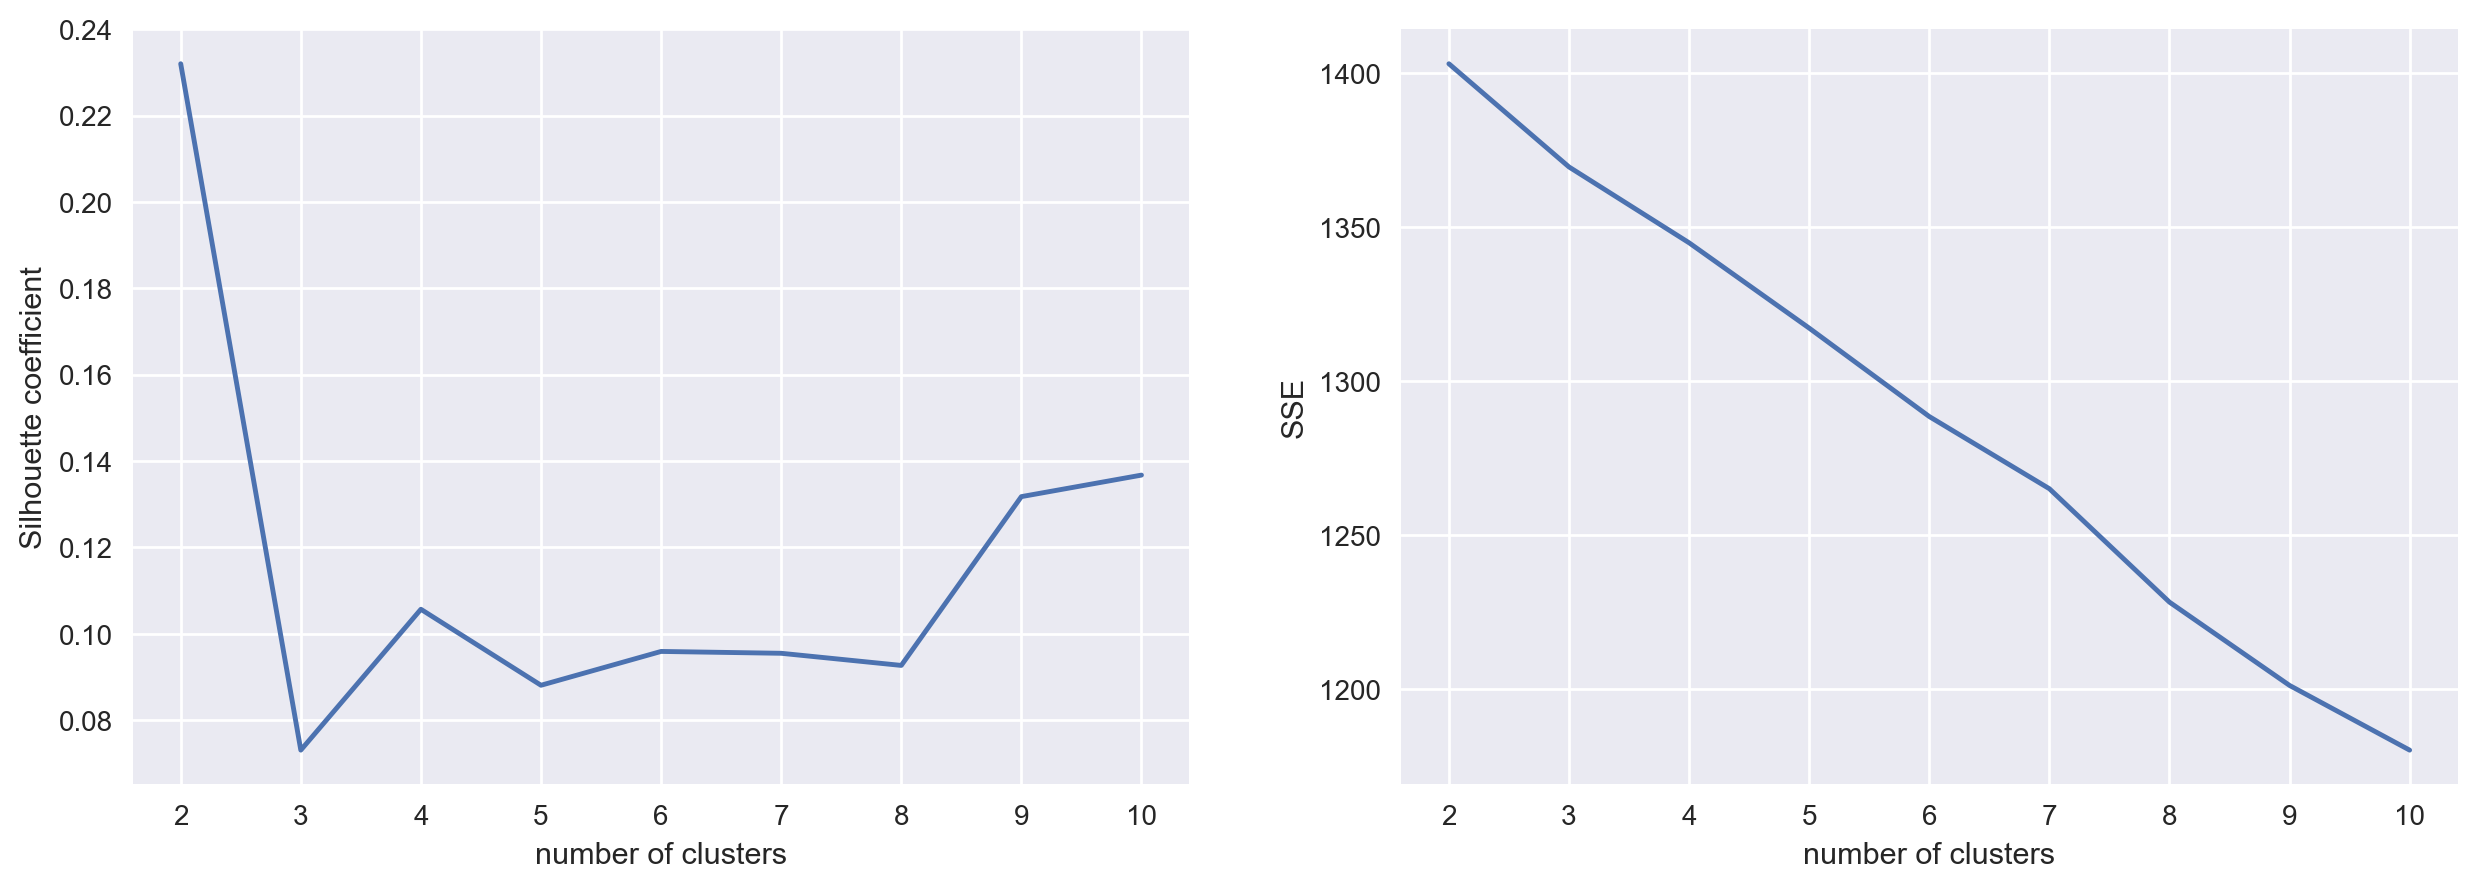

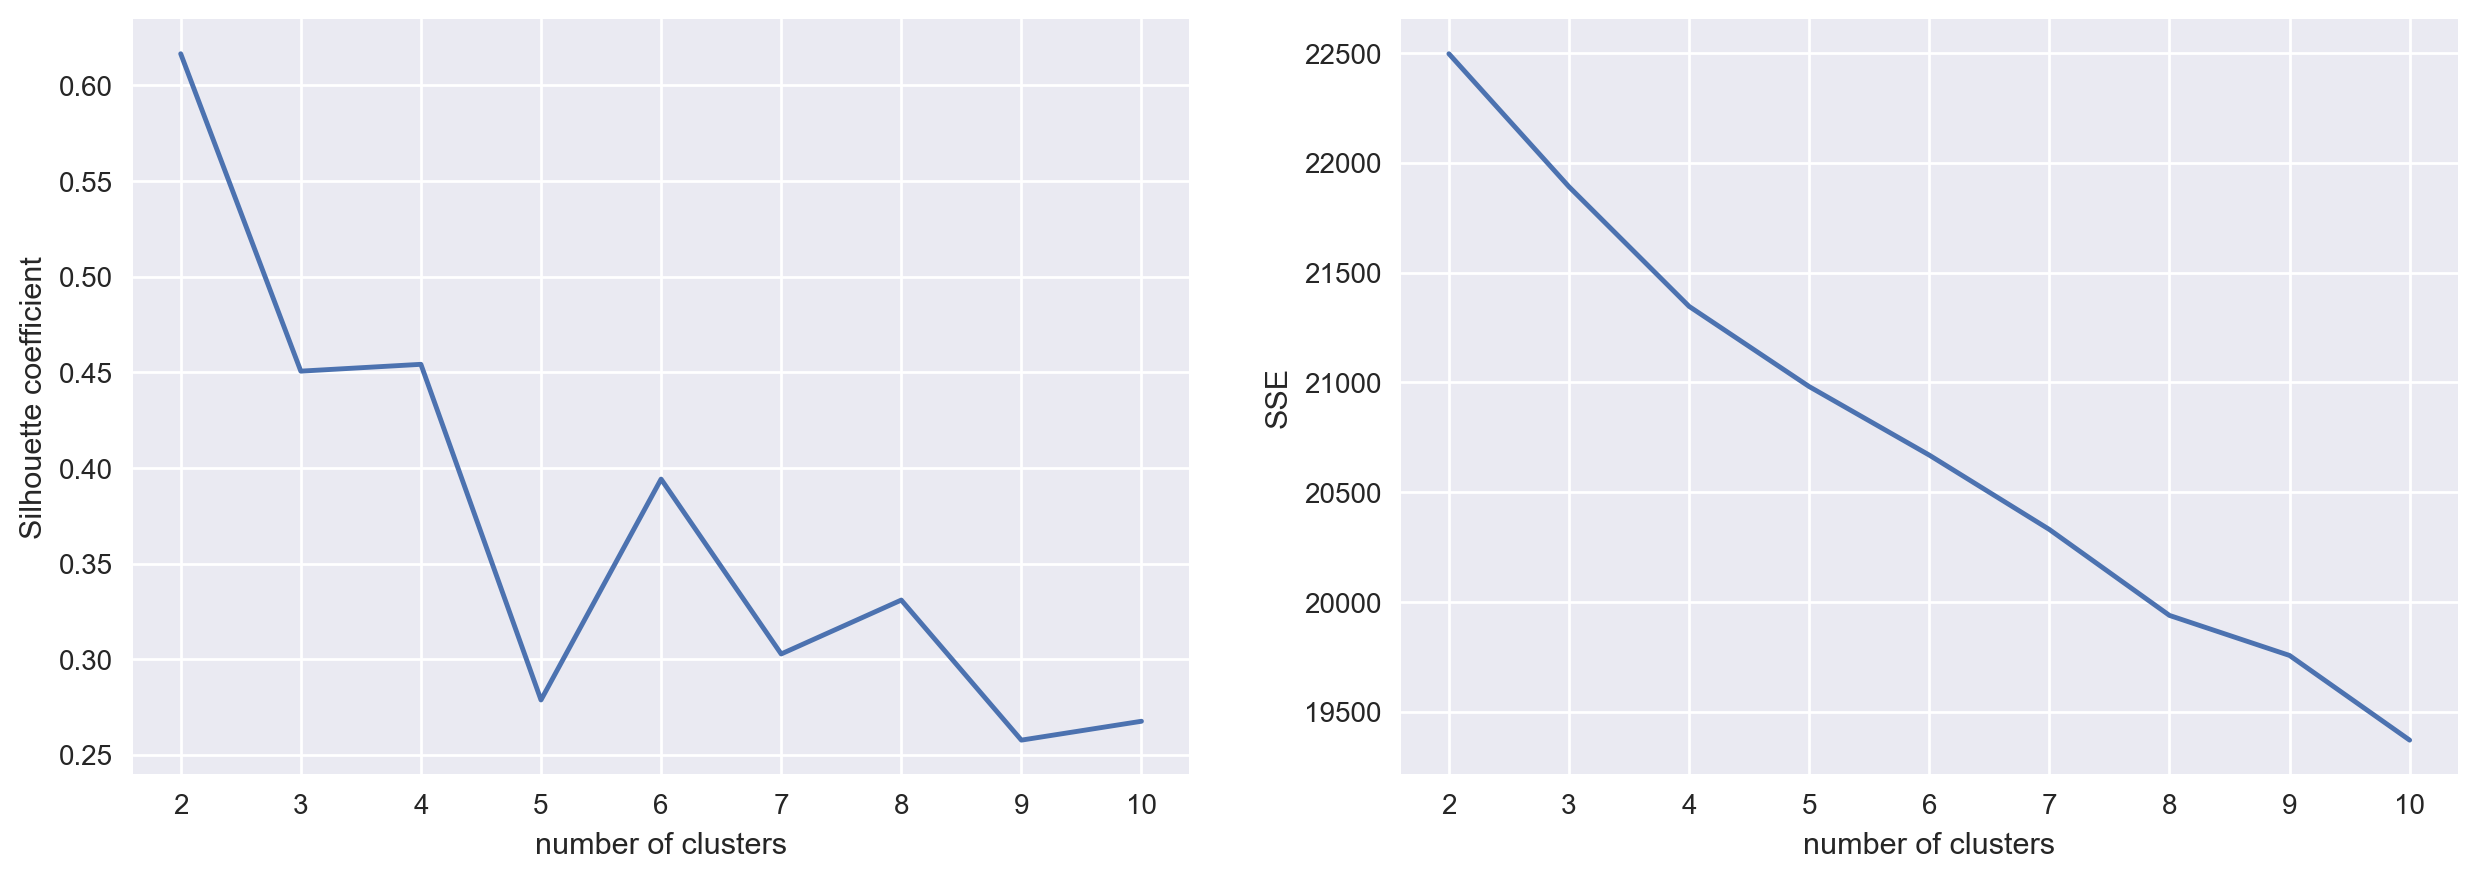

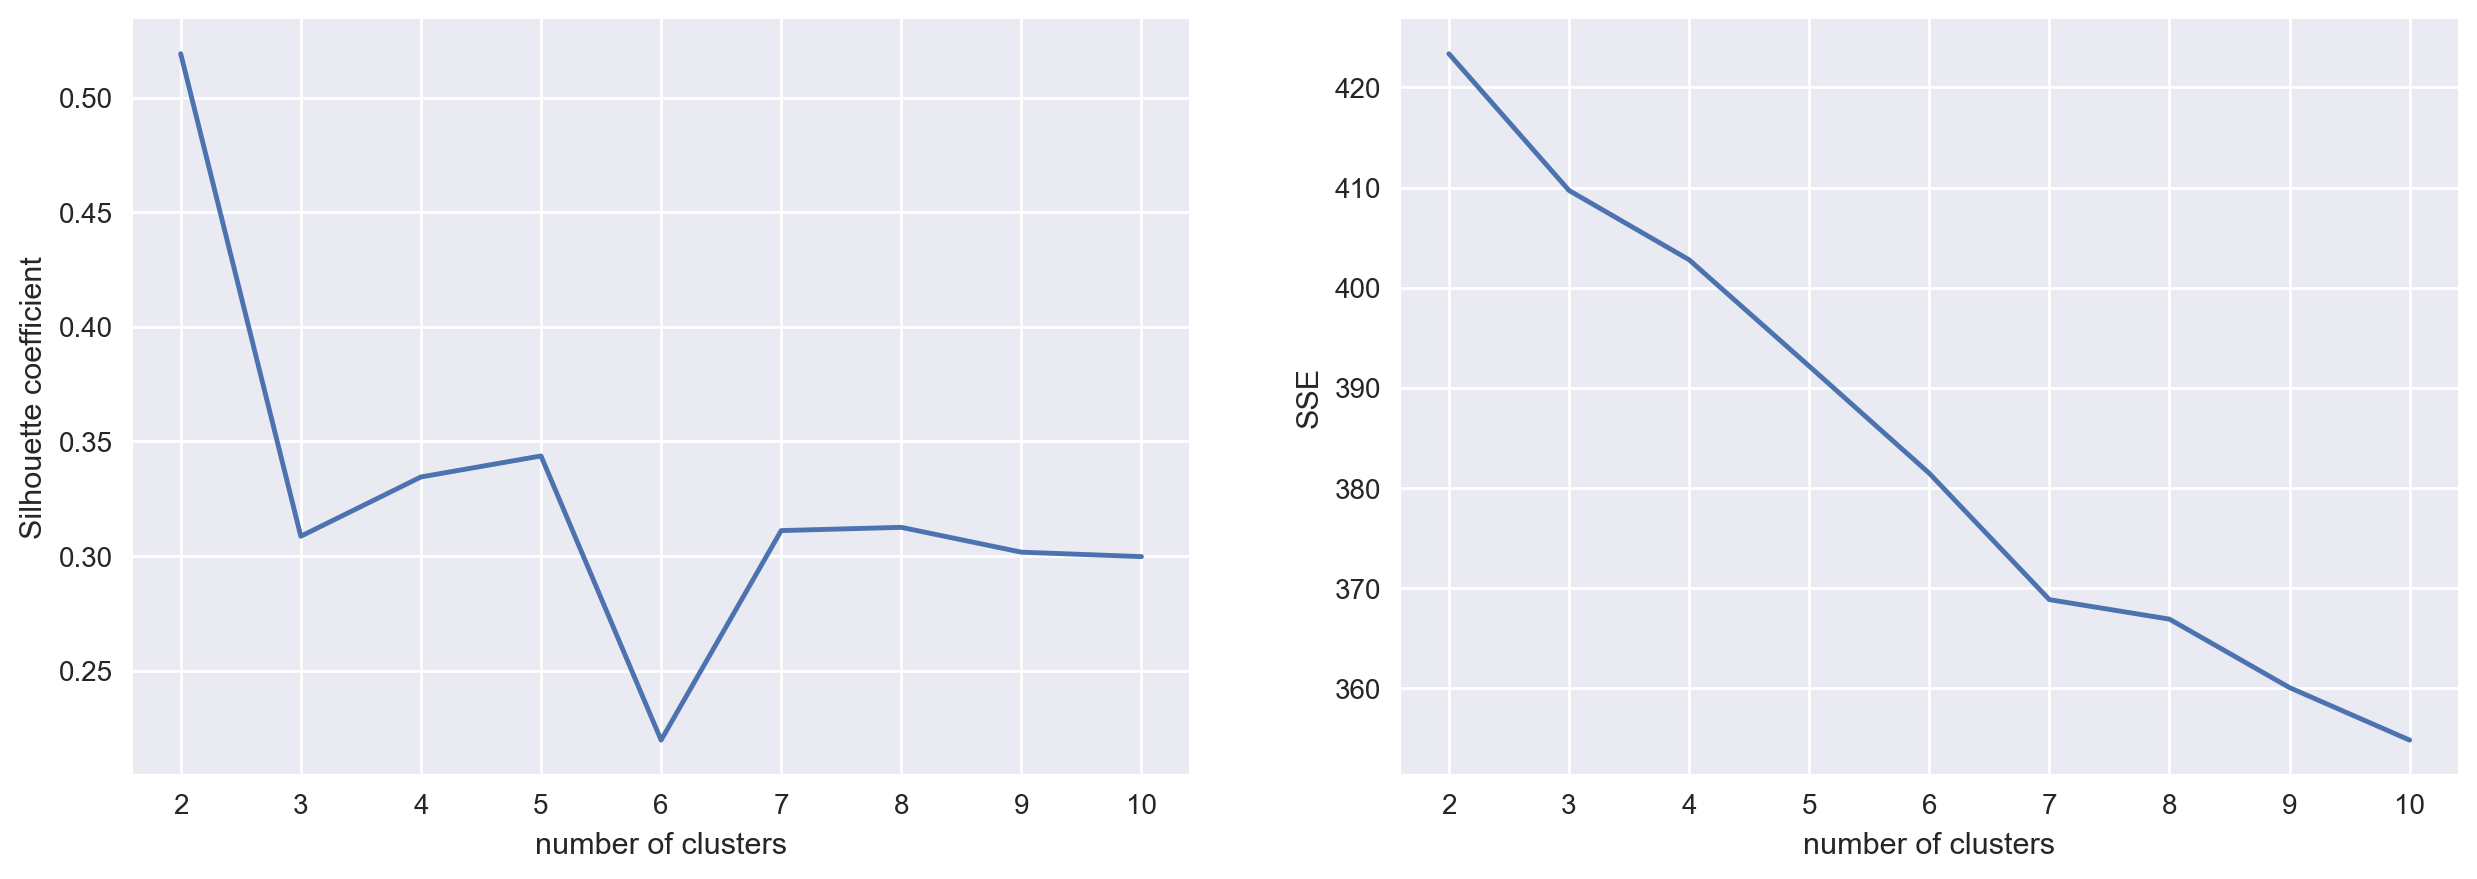

In [247]:
# min_df=0.002, max_feature =50

# Case 1: 'tfidf', 'svd', min_df=0.002, reduced_features=50
lsa_tfidf_0002_50 = KMeansEngine(X, 'tfidf', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_tfidf_0002_50.dimension_reduction('svd', reduction_max_features_=50)
lsa_tfidf_0002_50.KMeans_iterations(10)


# Case 2: 'count', 'svd', min_df=0.002, reduced_features=50
lsa_cv_0002_50 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_cv_0002_50.dimension_reduction('svd', reduction_max_features_=50)
lsa_cv_0002_50.KMeans_iterations(10)


# Case 3: 'count', 'nmf', min_df=0.002, reduced_features=50
nmf_cv_0002_50 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
nmf_cv_0002_50.dimension_reduction('nmf', reduction_max_features_=50)
nmf_cv_0002_50.KMeans_iterations(10)


# Plot for all three cases
lsa_tfidf_0002_50.draw_KMeans_plot()
lsa_cv_0002_50.draw_KMeans_plot()
nmf_cv_0002_50.draw_KMeans_plot()

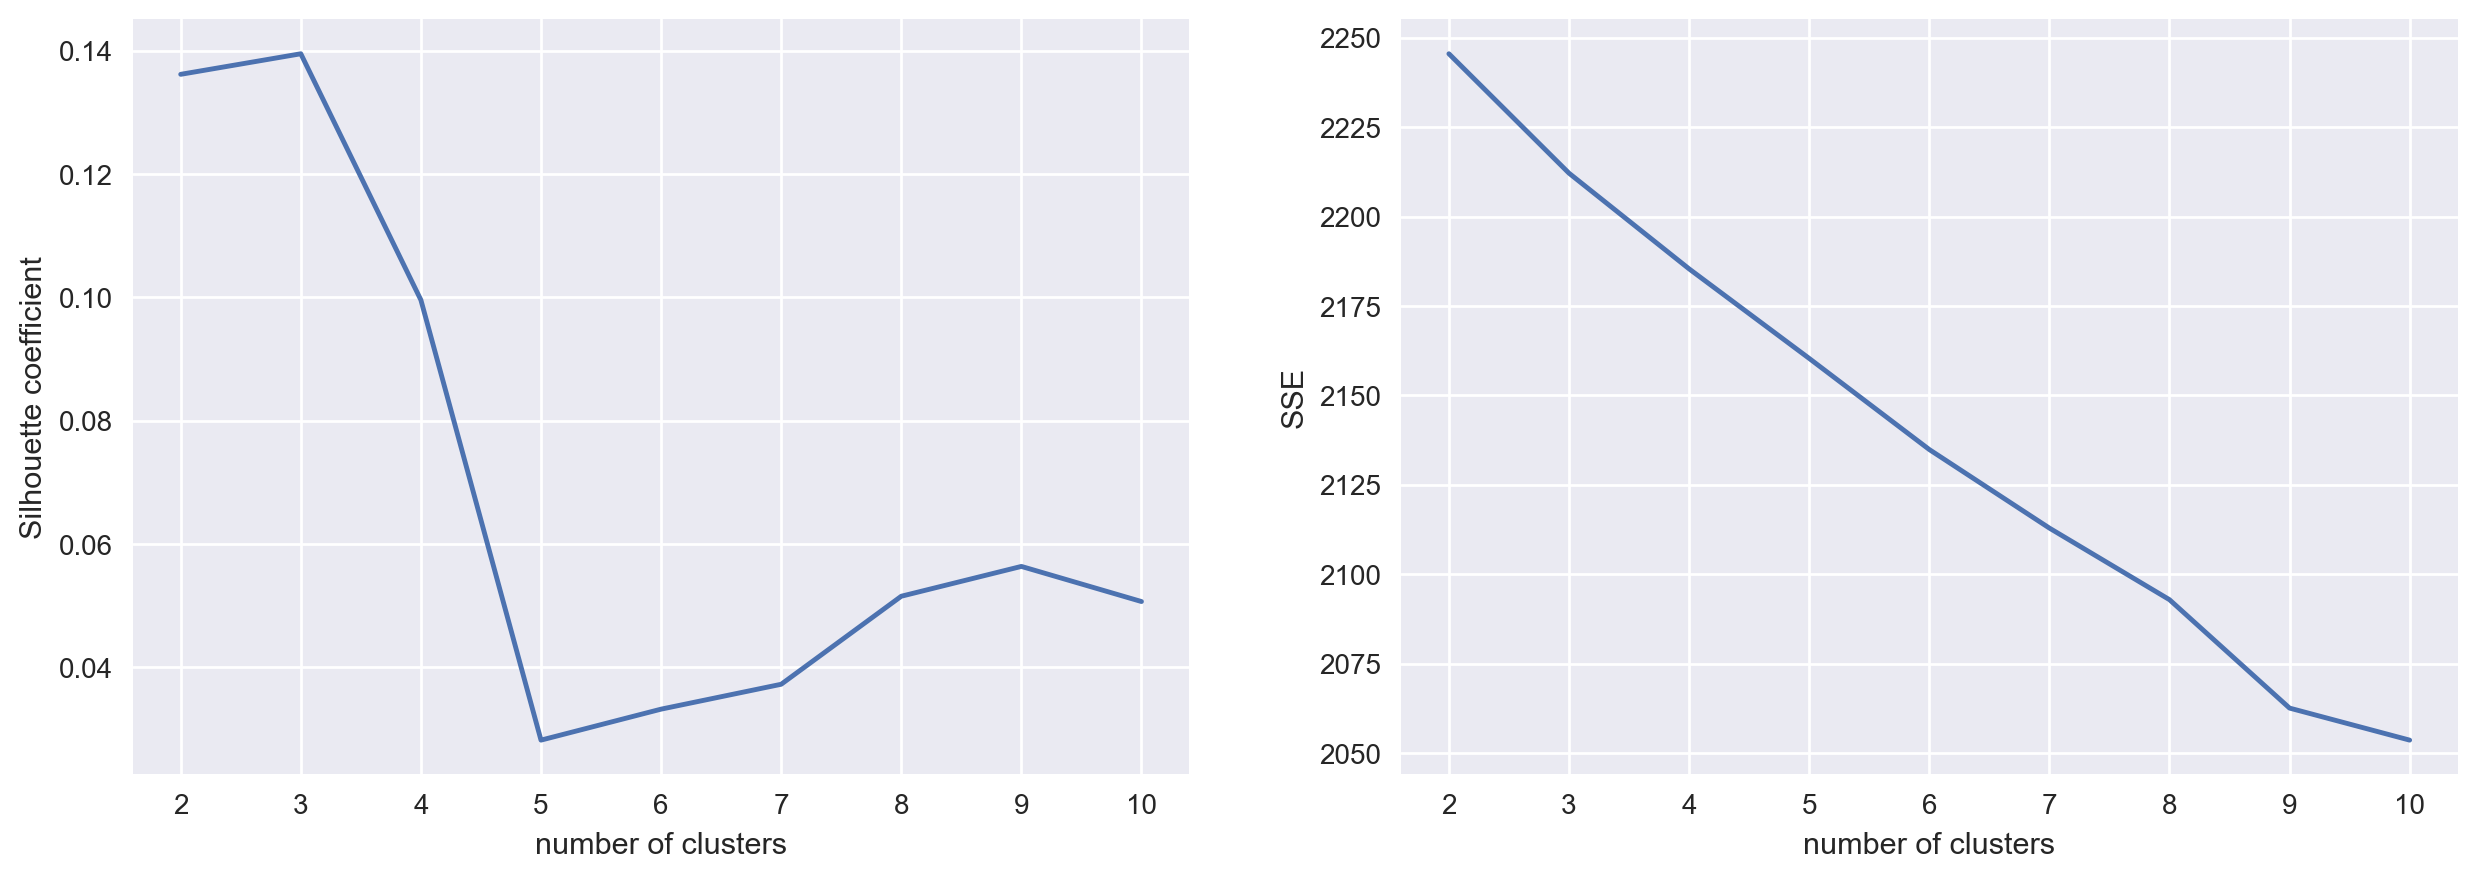

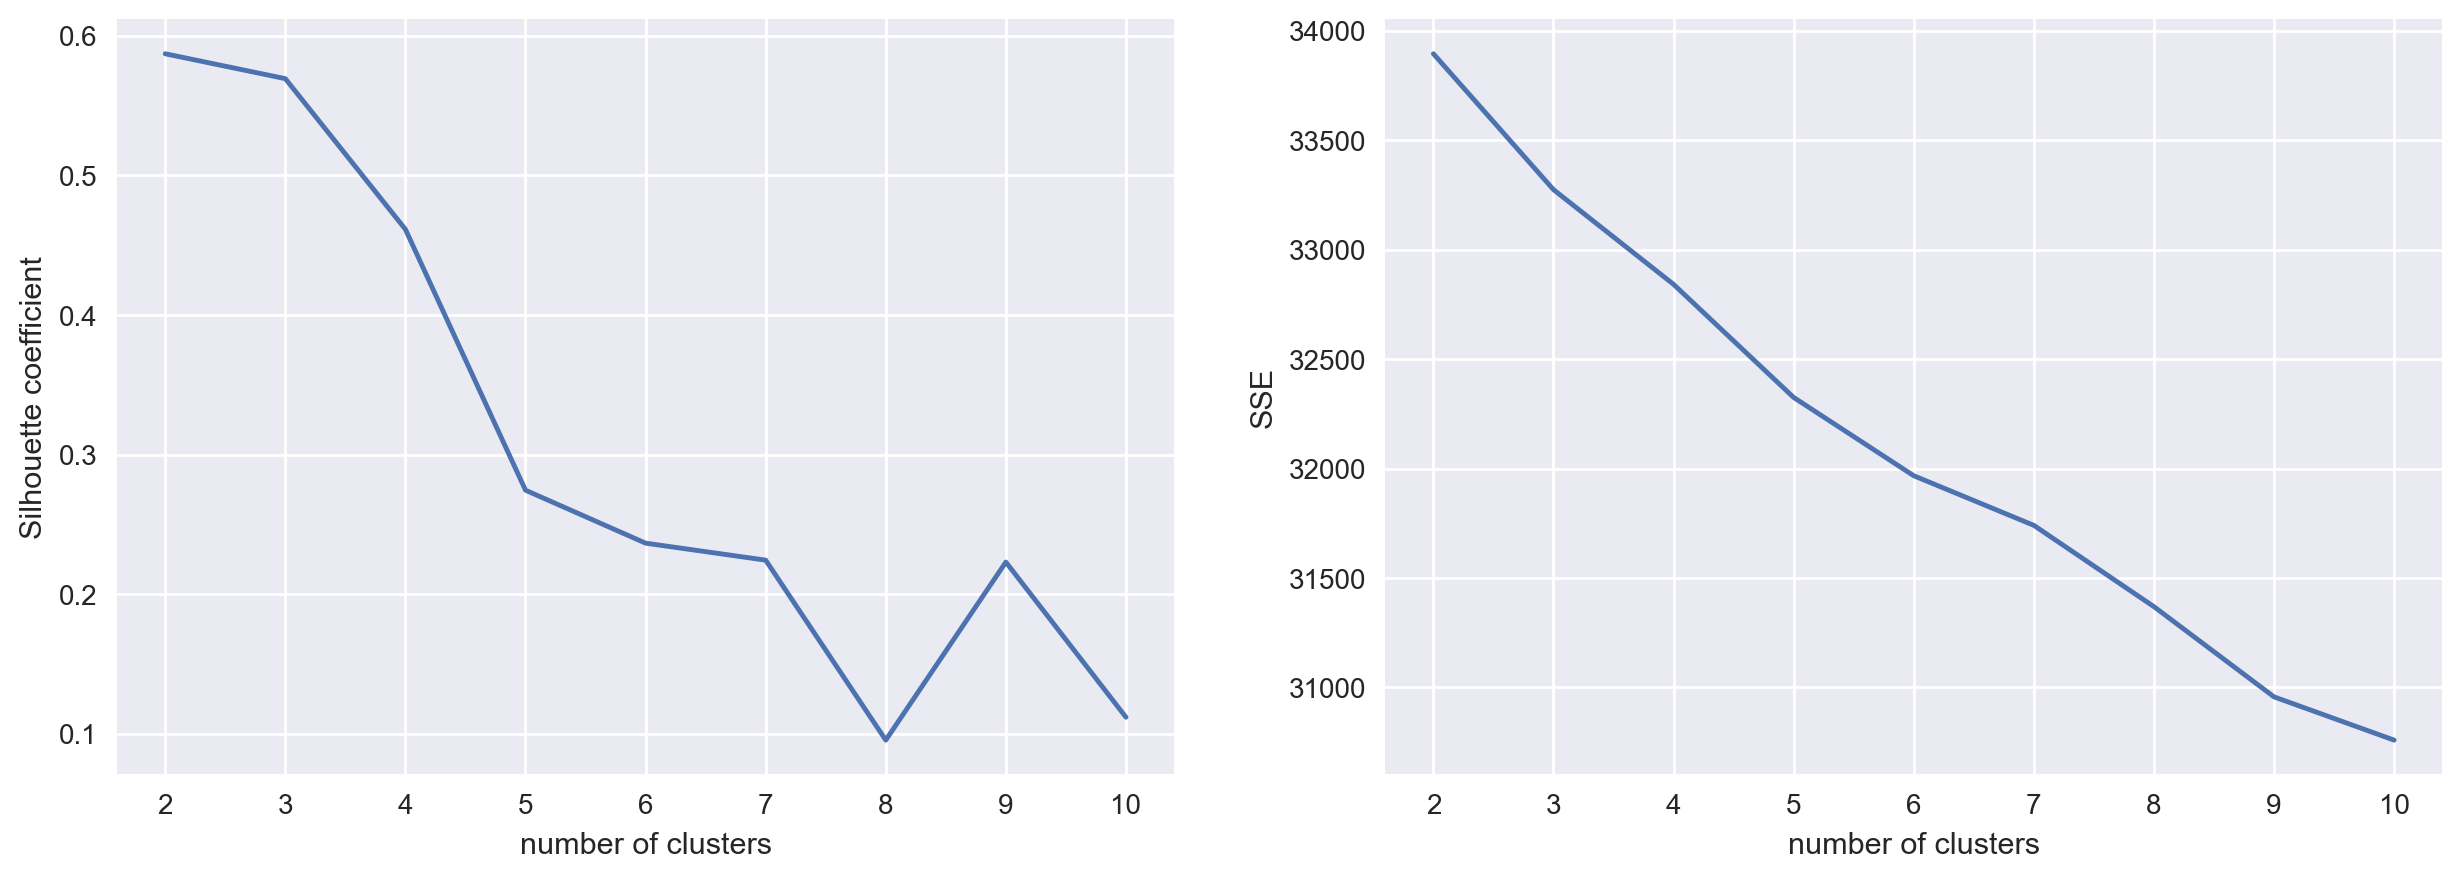

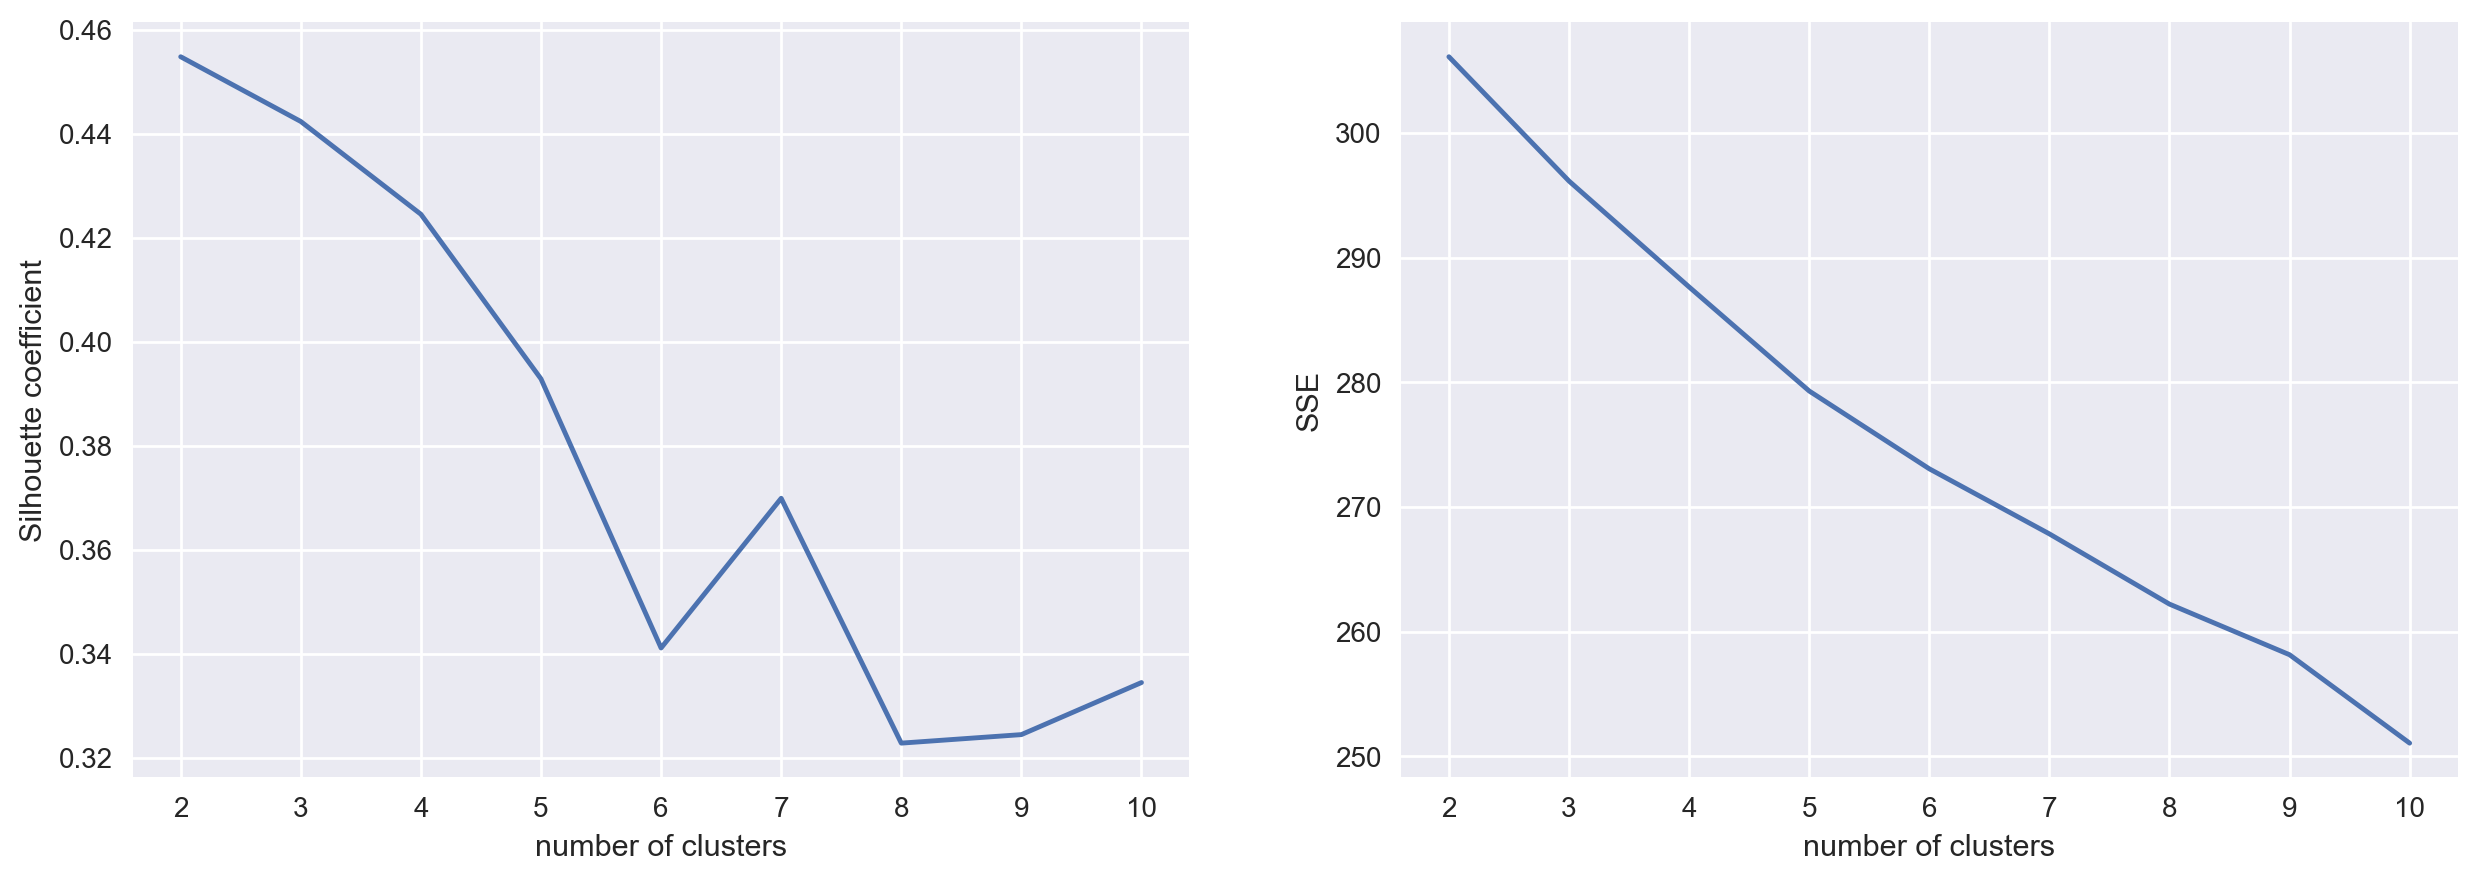

In [248]:
# min_df=0.002, max_feature =100

# Case 4: 'tfidf', 'svd', min_df=0.002, reduced_features=100
lsa_tfidf_0002_100 = KMeansEngine(X, 'tfidf', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_tfidf_0002_100.dimension_reduction('svd', reduction_max_features_=100)
lsa_tfidf_0002_100.KMeans_iterations(10)


# Case 5: 'count', 'svd', min_df=0.002, reduced_features=100
lsa_cv_0002_100 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_cv_0002_100.dimension_reduction('svd', reduction_max_features_=100)
lsa_cv_0002_100.KMeans_iterations(10)


# Case 6: 'count', 'nmf', min_df=0.002, reduced_features=100
nmf_cv_0002_100 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
nmf_cv_0002_100.dimension_reduction('nmf', reduction_max_features_=100)
nmf_cv_0002_100.KMeans_iterations(10)


# Plot for all three cases
lsa_tfidf_0002_100.draw_KMeans_plot()
lsa_cv_0002_100.draw_KMeans_plot()
nmf_cv_0002_100.draw_KMeans_plot()

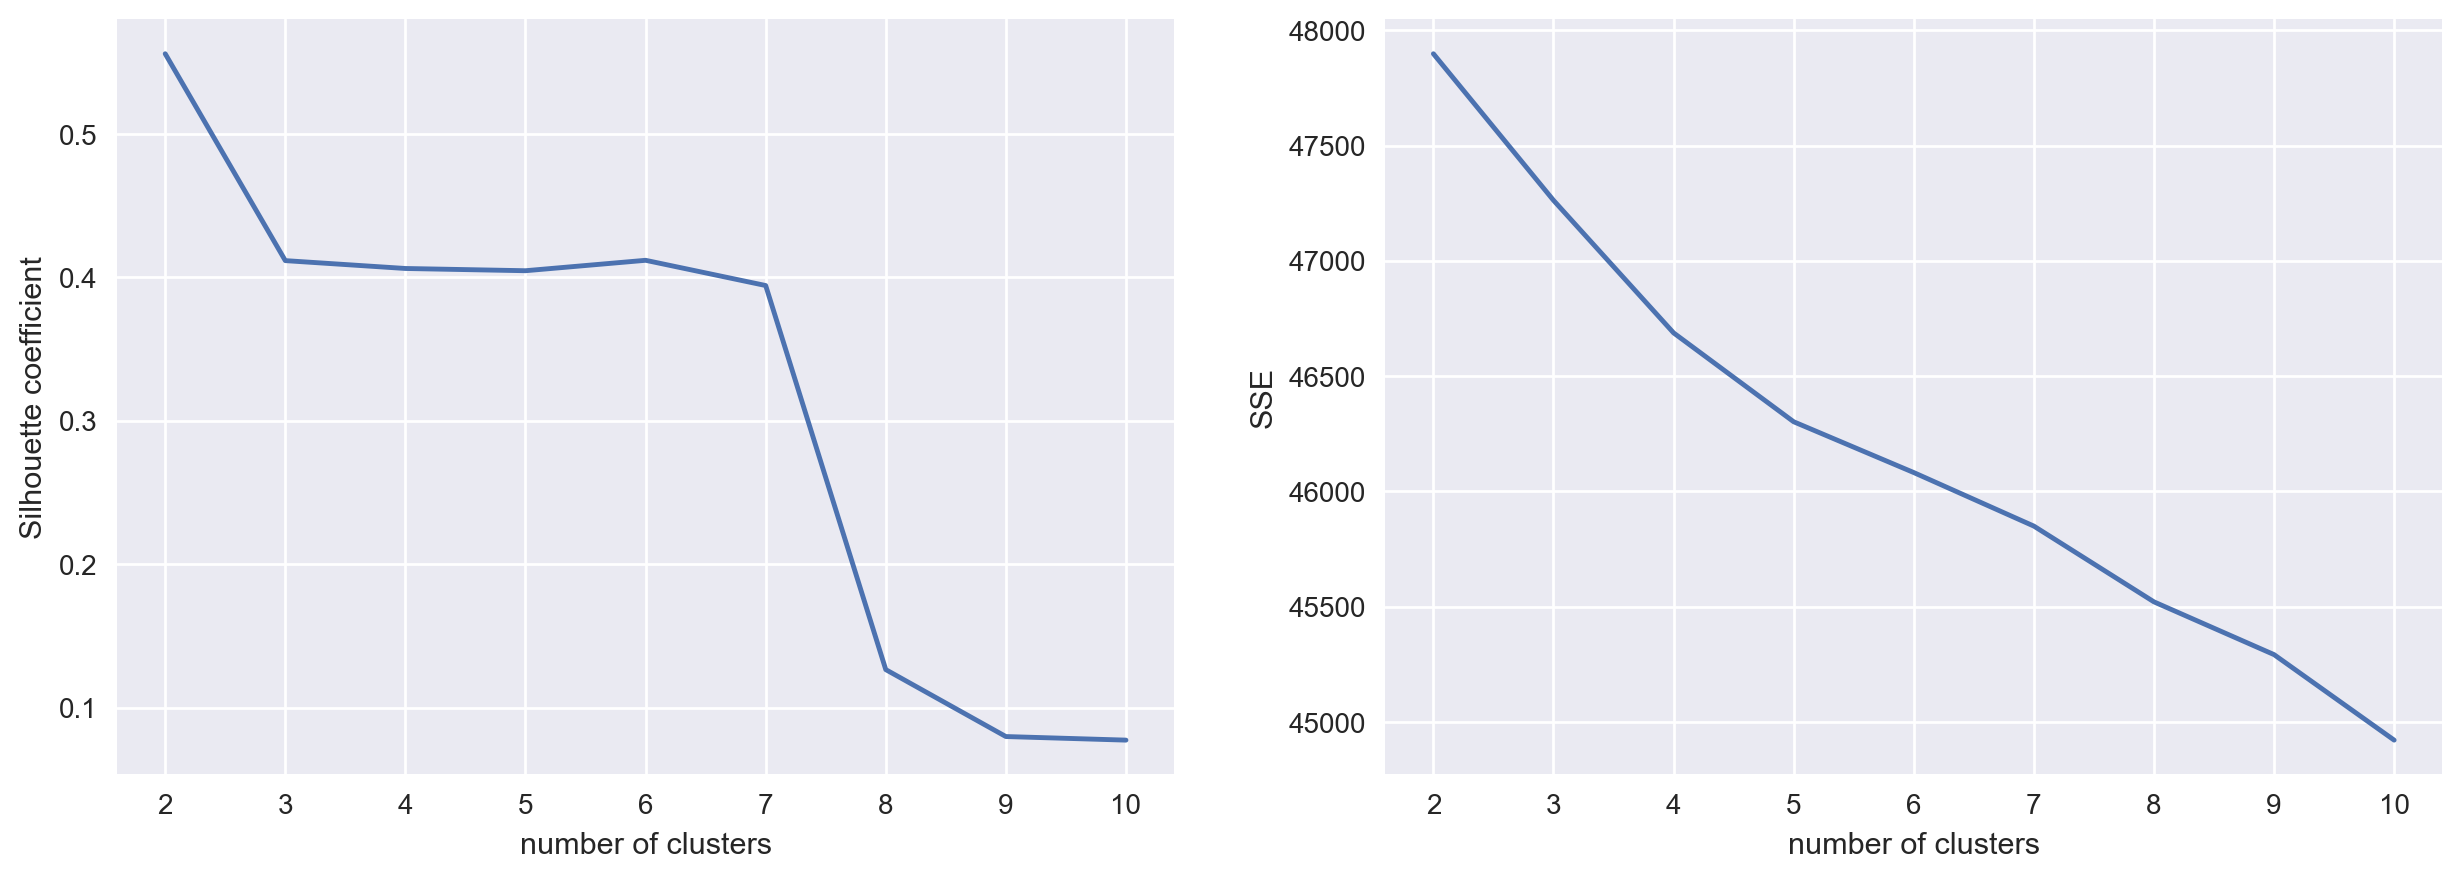

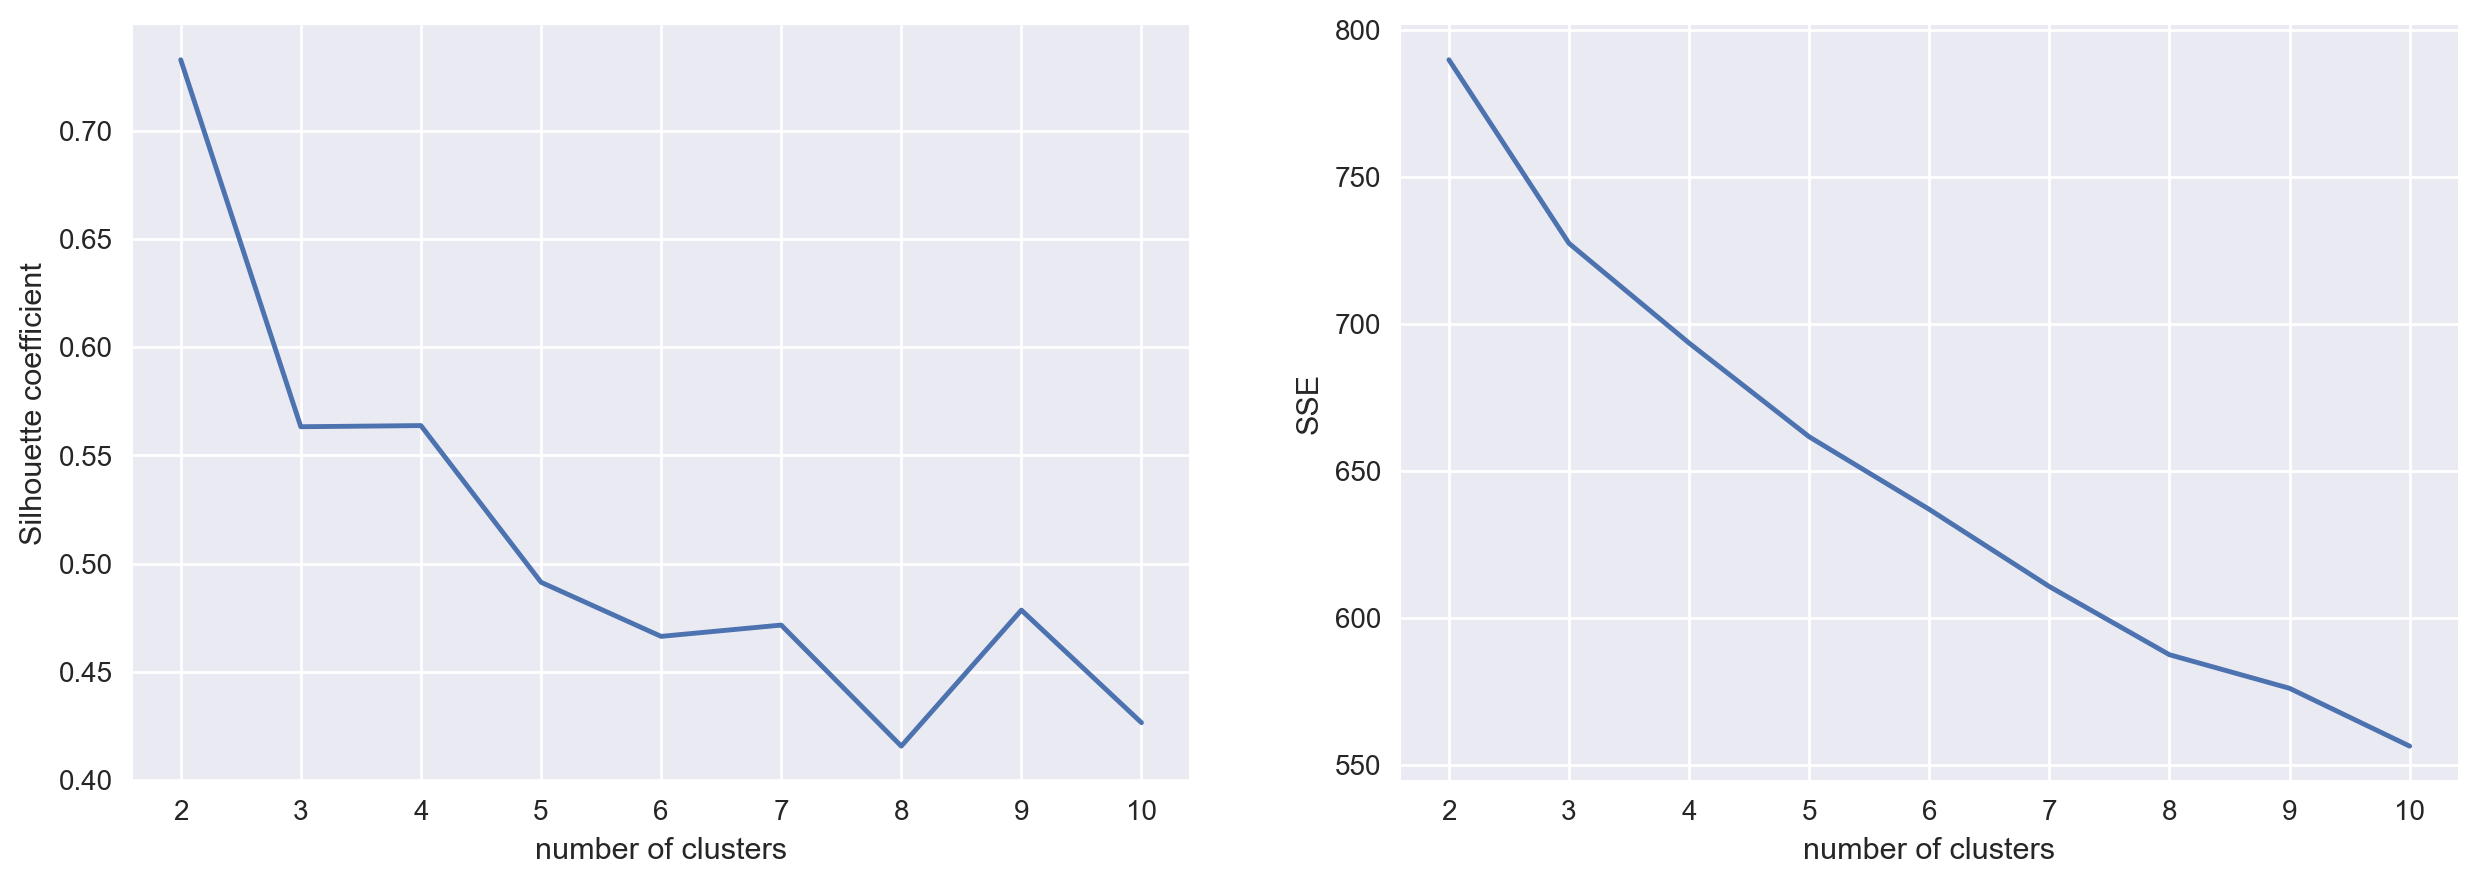

In [249]:
# min_df=0.002, max_feature =200

# Case 7: 'tfidf', 'svd', min_df=0.002, reduced_features=200
lsa_tfidf_0002_200 = KMeansEngine(X, 'tfidf', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_tfidf_0002_200.dimension_reduction('svd', reduction_max_features_=200)
lsa_tfidf_0002_200.KMeans_iterations(10)


# Case 8: 'count', 'svd', min_df=0.002, reduced_features=200
lsa_cv_0002_200 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
lsa_cv_0002_200.dimension_reduction('svd', reduction_max_features_=200)
lsa_cv_0002_200.KMeans_iterations(10)


# Case 9: 'count', 'nmf', min_df=0.002, reduced_features=200
nmf_cv_0002_200 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.002, vector_max_features_=2000)
nmf_cv_0002_200.dimension_reduction('nmf', reduction_max_features_=200)
nmf_cv_0002_200.KMeans_iterations(10)


# Plot for all three cases
lsa_tfidf_0002_200.draw_KMeans_plot()
lsa_cv_0002_200.draw_KMeans_plot()
nmf_cv_0002_200.draw_KMeans_plot()


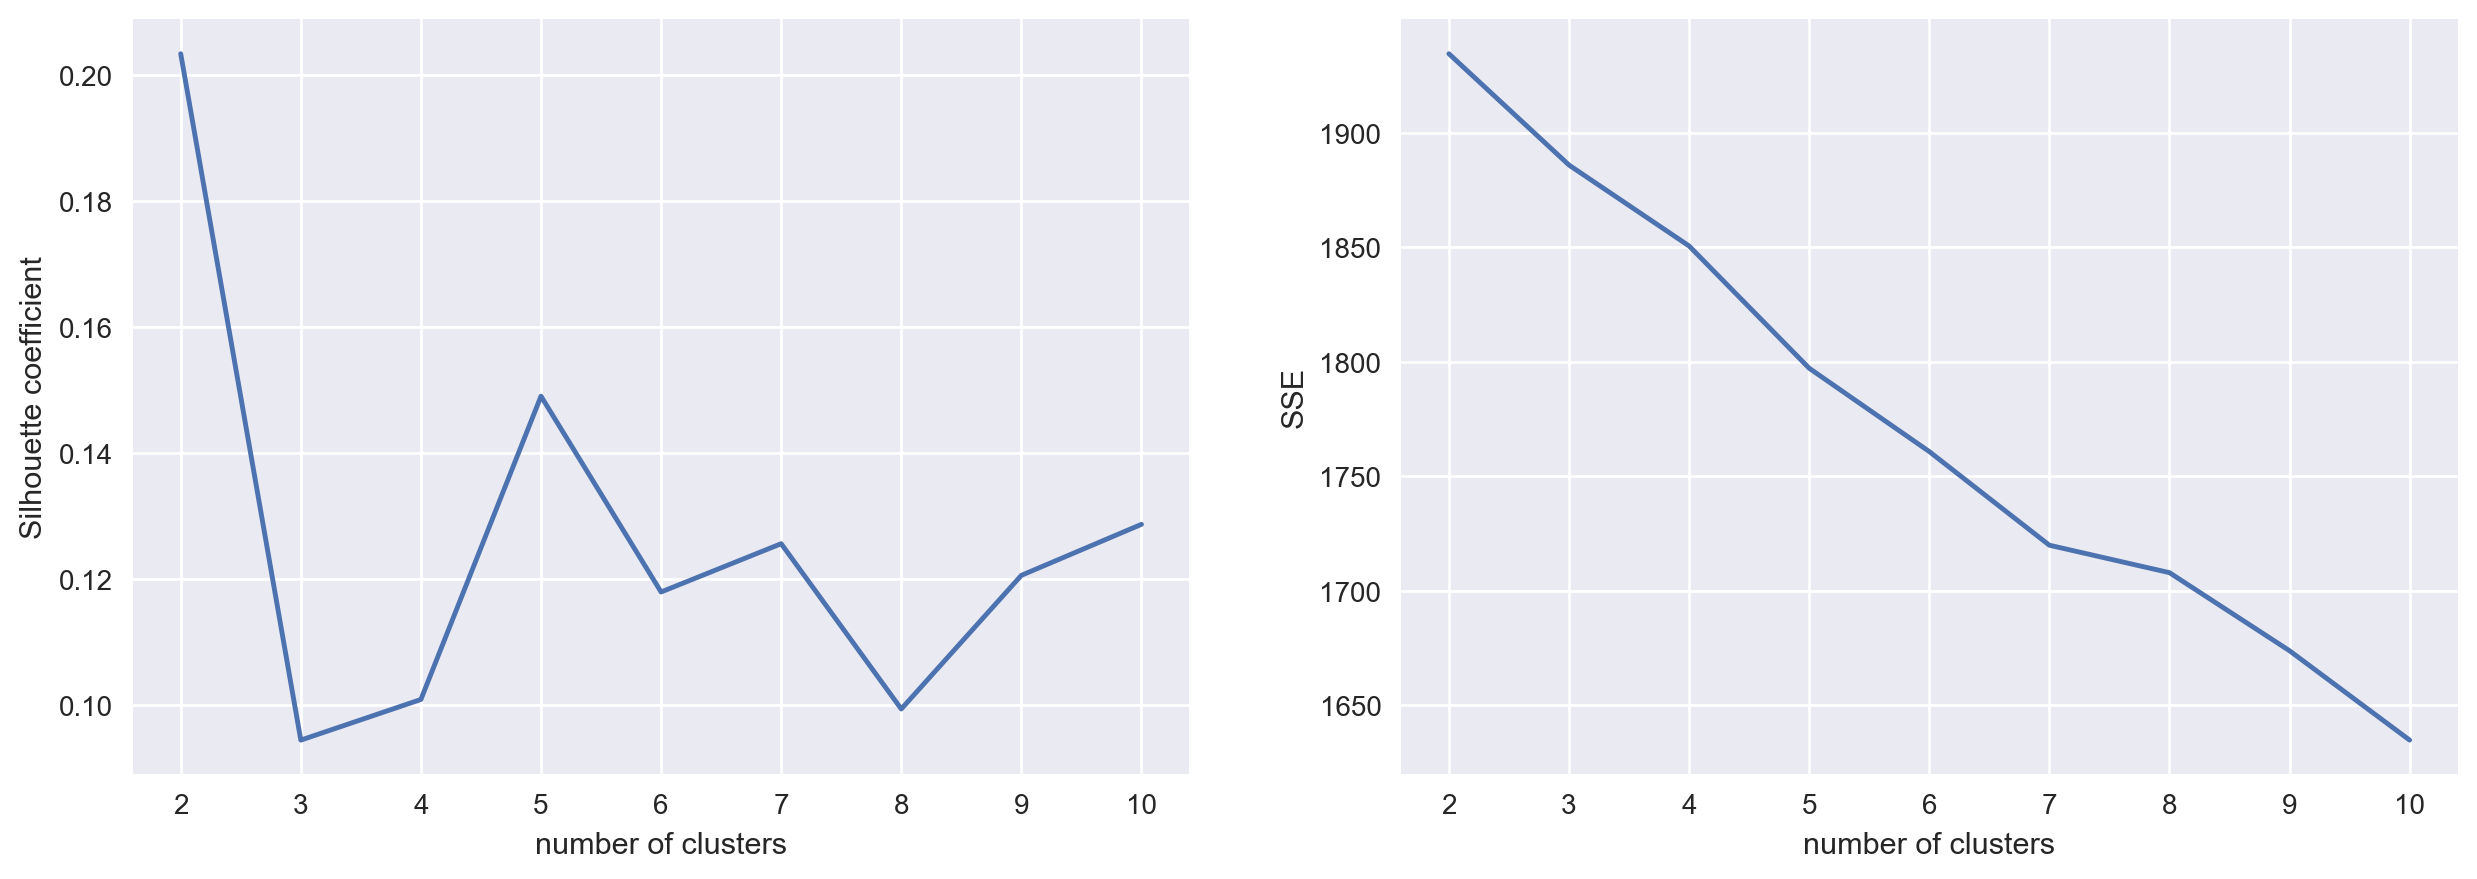

In [250]:
# min_df=0.005, max_feature =50

# Case 10: 'tfidf', 'svd', min_df=0.005, reduced_features=50
lsa_tfidf_0005_50 = KMeansEngine(X, 'tfidf', max_df_=0.05, min_df_=0.005, vector_max_features_=2000)
lsa_tfidf_0005_50.dimension_reduction('svd', reduction_max_features_=50)
lsa_tfidf_0005_50.KMeans_iterations(10)


# Case 11: 'count', 'svd', min_df=0.005, reduced_features=50
lsa_cv_0005_50 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.005, vector_max_features_=2000)
lsa_cv_0005_50.dimension_reduction('svd', reduction_max_features_=50)
lsa_cv_0005_50.KMeans_iterations(10)


# Case 12: 'count', 'nmf', min_df=0.005, reduced_features=50
nmf_cv_0005_50 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.005, vector_max_features_=2000)
nmf_cv_0005_50.dimension_reduction('nmf', reduction_max_features_=50)
nmf_cv_0005_50.KMeans_iterations(10)


# Plot for all three cases
lsa_tfidf_0005_50.draw_KMeans_plot()
lsa_cv_0005_50.draw_KMeans_plot()
nmf_cv_0005_50.draw_KMeans_plot()

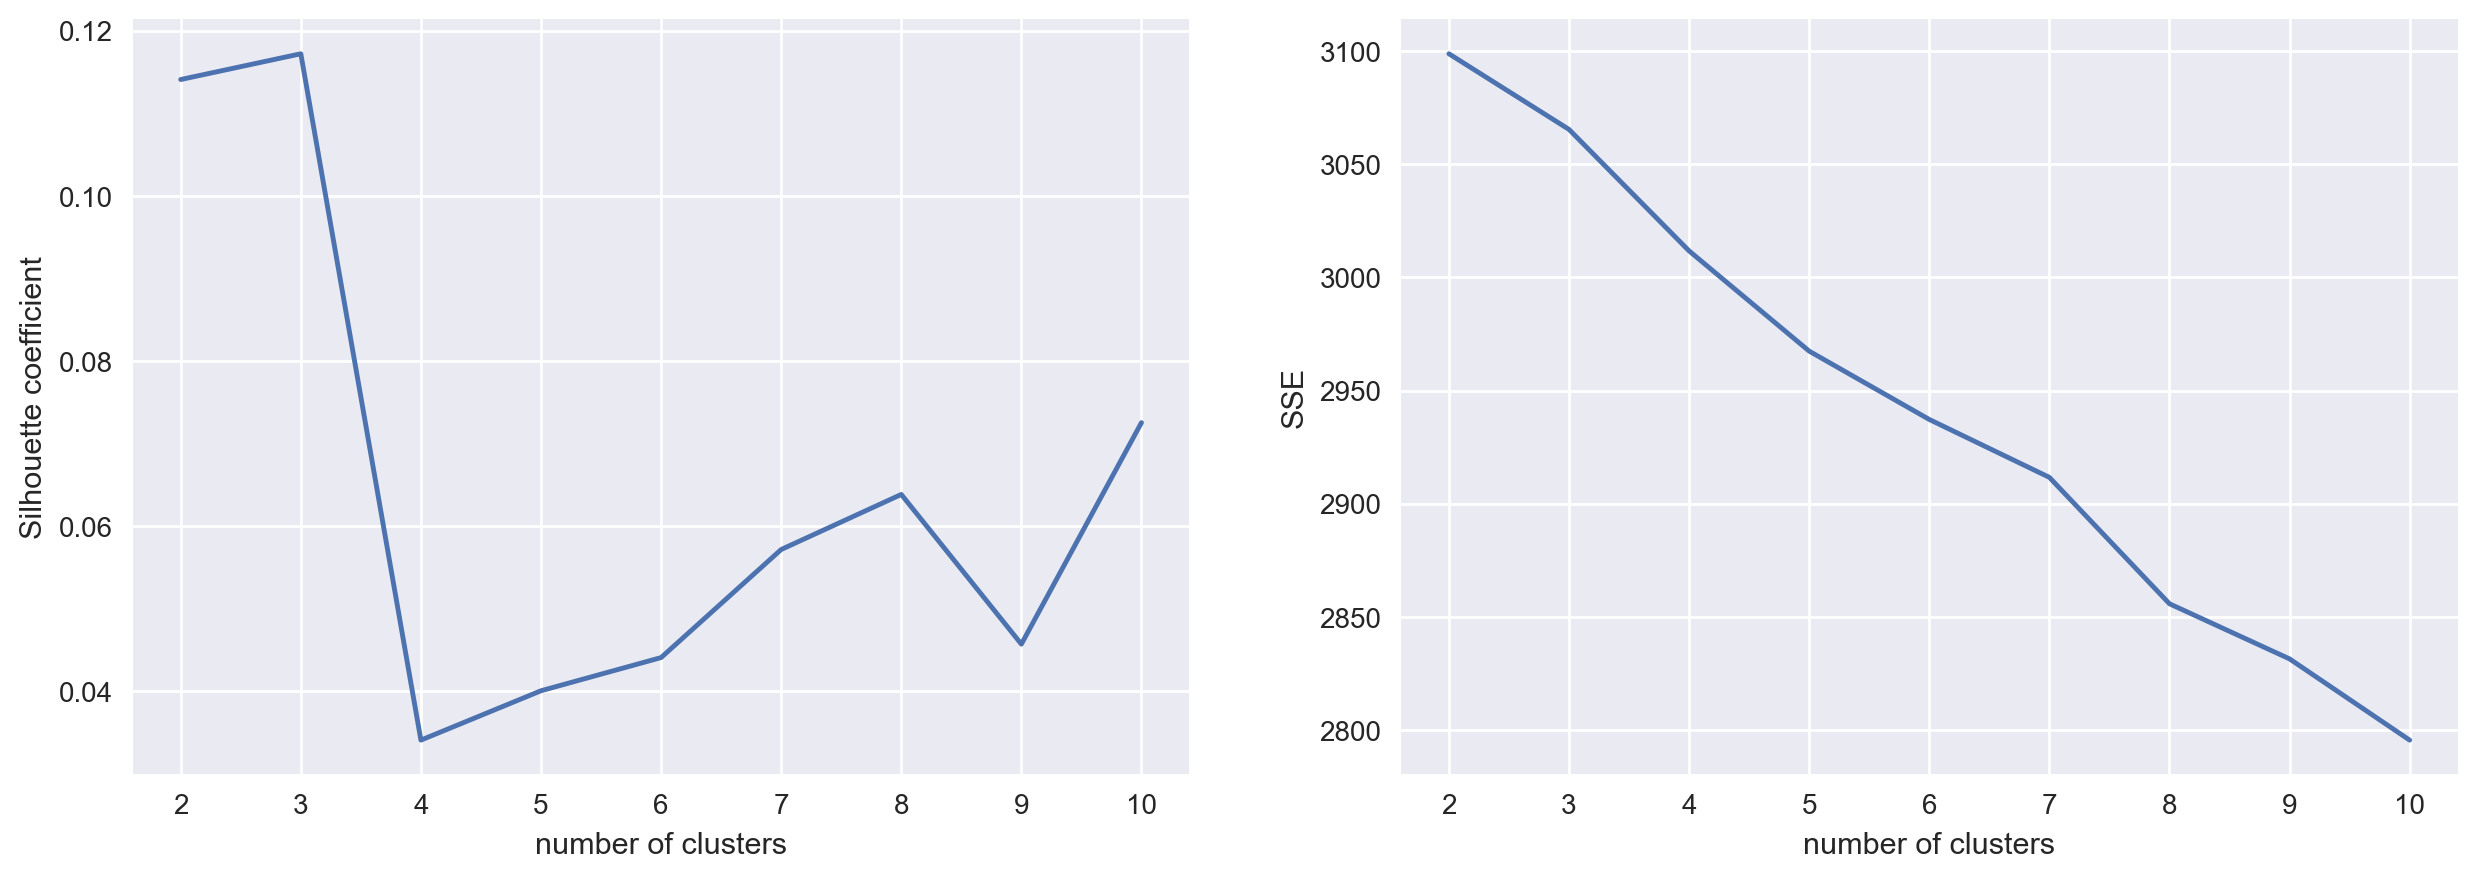

In [251]:
# min_df=0.005, max_feature =100

# Case 13: 'tfidf', 'svd', min_df=0.005, reduced_features=100
lsa_tfidf_0005_100 = KMeansEngine(X, 'tfidf', max_df_=0.05, min_df_=0.005, vector_max_features_=2000)
lsa_tfidf_0005_100.dimension_reduction('svd', reduction_max_features_=100)
lsa_tfidf_0005_100.KMeans_iterations(10)


# Case 14: 'count', 'svd', min_df=0.005, reduced_features=100
lsa_cv_0005_100 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.005, vector_max_features_=2000)
lsa_cv_0005_100.dimension_reduction('svd', reduction_max_features_=100)
lsa_cv_0005_100.KMeans_iterations(10)


# Case 15: 'count', 'nmf', min_df=0.005, reduced_features=100
nmf_cv_0005_100 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.005, vector_max_features_=2000)
nmf_cv_0005_100.dimension_reduction('nmf', reduction_max_features_=100)
nmf_cv_0005_100.KMeans_iterations(10)


# Plot for all three cases
lsa_tfidf_0005_100.draw_KMeans_plot()
lsa_cv_0005_100.draw_KMeans_plot()
nmf_cv_0005_100.draw_KMeans_plot()

In [252]:
# min_df=0.005, max_feature =200

# Case 16: 'tfidf', 'svd', min_df=0.005, reduced_features=200
lsa_tfidf_0005_200 = KMeansEngine(X, 'tfidf', max_df_=0.05, min_df_=0.005, vector_max_features_=2000)
lsa_tfidf_0005_200.dimension_reduction('svd', reduction_max_features_=200)
lsa_tfidf_0005_200.KMeans_iterations(10)


# Case 17: 'count', 'svd', min_df=0.005, reduced_features=200
lsa_cv_0005_200 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.005, vector_max_features_=2000)
lsa_cv_0005_200.dimension_reduction('svd', reduction_max_features_=200)
lsa_cv_0005_200.KMeans_iterations(10)


# Case 18: 'count', 'nmf', min_df=0.005, reduced_features=200
nmf_cv_0005_200 = KMeansEngine(X, 'count', max_df_=0.05, min_df_=0.005, vector_max_features_=2000)
nmf_cv_0005_200.dimension_reduction('nmf', reduction_max_features_=200)
nmf_cv_0005_200.KMeans_iterations(10)


# Plot for all three cases
lsa_tfidf_0005_200.draw_KMeans_plot()
lsa_cv_0005_200.draw_KMeans_plot()
nmf_cv_0005_200.draw_KMeans_plot()

In [273]:
# optimized model is nmf_cv_0002_100

km_optimized = nmf_cv_0005_50.KMeans_model(2)
labels = km_optimized.labels_

In [257]:
# Create a list of models for pickle

model_list=[lsa_tfidf_0002_50, lsa_cv_0002_50, nmf_cv_0002_50,
           lsa_tfidf_0002_100, lsa_cv_0002_100, nmf_cv_0002_100,
           lsa_tfidf_0002_200, lsa_cv_0002_200, nmf_cv_0002_200,
           lsa_tfidf_0005_50, lsa_cv_0005_50, nmf_cv_0005_50,
           lsa_tfidf_0005_100, lsa_cv_0005_100, nmf_cv_0005_100,
           lsa_tfidf_0005_200, lsa_cv_0005_200, nmf_cv_0005_200]

In [274]:
# This is to load pickle file if data is available,
# or store data when pickle file isn't available

pkl_path2 = '/Users/xzhou/github/project_files/amazon/amazon_optimized_km.pkl'

try:    
    with open(pkl_path2, 'rb') as pkl_file:
        km_optimized = pickle.load(pkl_file)
except:
    with open(pkl_path2, 'wb') as pkl_file:
        pickle.dump(km_optimized, pkl_file)

In [259]:
# This is to load pickle file if data is available,
# or store data when pickle file isn't available

pkl_path3 = '/Users/xzhou/github/project_files/amazon/amazon_km_models.pkl'
models = {}

try:    
    with open(pkl_path3, 'rb') as pkl_file:
        for i in range (18):
            models[i] = pickle.load(pkl_file)
except:
    with open(pkl_path3, 'wb') as pkl_file:
        for item in model_list:
            pickle.dump(item, pkl_file)

In [33]:
# how to save the model?
# This is to load pickle file if data is available,
# or store data when pickle file isn't available

# pkl_path3 = '/Users/xzhou/github/project_files/amazon/amazon_km_7clusters.pkl'

# try:    
#     with open(pkl_path2, 'rb') as pkl_file:
#         km_optimized = pickle.load(pkl_file)
# except:
#     with open(pkl_path2, 'wb') as pkl_file:
#         pickle.dump(km_optimized, pkl_file)

In [34]:
centroids = km_optimized.cluster_centers_

In [37]:
centroids.shape

(7, 20)

In [68]:
centroids_reversed = lsa_tfidf.inverse_transform(centroids)

In [69]:
print (centroids_reversed)

[[ 7.72212608e-04  2.00478620e-03  6.98795681e-03 ...  1.96376174e-03
   6.63016635e-04  1.82930320e-03]
 [ 6.74796221e-04  3.44773078e-03  1.06214169e-02 ...  2.48335537e-03
   1.50592339e-04  1.02356018e-03]
 [ 1.35230882e-04 -2.59872452e-06  5.02501606e-03 ...  3.37616974e-03
   2.67414294e-04 -5.07183931e-04]
 ...
 [ 4.10341929e-04  4.69550135e-03  1.71112492e-02 ...  1.40836674e-03
   4.39297509e-04  4.20126386e-03]
 [ 2.69704035e-04  4.85362051e-04  8.23400197e-04 ...  6.34470814e-04
   1.02773149e-05  2.98386370e-03]
 [ 1.00464311e-03  5.30195937e-03  2.28247122e-02 ...  3.26624729e-03
   9.18285382e-04  3.85061743e-03]]


In [275]:
df['label'] = labels

In [276]:
df

rating       date                                             review  \
2          4 2018-07-31  Sometimes while playing a game, you can answer...   
3          5 2018-07-31  I have had a lot of fun with this thing. My 4 ...   
5          5 2018-07-31  I received the echo as a gift. I needed anothe...   
6          3 2018-07-31  Without having a cellphone, I cannot use many ...   
7          5 2018-07-31  I think this is the 5th one I've purchased. I'...   
9          5 2018-07-30  Love it! I’ve listened to songs I haven’t hear...   
10         5 2018-07-30  I sent it to my 85 year old Dad, and he talks ...   
11         5 2018-07-30  I love it! Learning knew things with it eveyda...   
12         5 2018-07-30  I purchased this for my mother who is having k...   
13         5 2018-07-30                                 Love, Love, Love!!   
14         5 2018-07-30                           Just what I expected....   
15         5 2018-07-30                          I love it, wife hates it.   
16         5 2018-07-30  Really happy with this purchase.  Great speake...   
17         5 2018-07-30  We have only been using Alexa for a couple of ...   
18         5 2018-07-30  We love the size of the 2nd generation echo. S...   
19         4 2018-07-30  I liked the original Echo. This is the same bu...   
20         5 2018-07-30  Love the Echo and how good the music sounds pl...   
21         5 2018-07-30  We love Alexa! We use her to play music, play ...   
22         4 2018-07-30  Have only had it set up for a few days. Still ...   
23         5 2018-07-30  I love it. It plays my sleep sounds immediatel...   
24         3 2018-07-30  I got a second unit for the bedroom, I was exp...   
26         5 2018-07-30  I love my Echo. It's easy to operate, loads of...   
27         5 2018-07-30                          Sounds great!! Love them!   
28         4 2018-07-30  Fun item to play with and get used to using.  ...   
29         5 2018-07-30                            Just like the other one   
30         5 2018-07-30  Still learning all the capabilities...but so f...   
32         5 2018-07-30  She works well. Needs a learning command  for ...   
33         3 2018-07-30  The speakers sound pretty good for being so sm...   
34         5 2018-07-30                            This device is awesome!   
35         5 2018-07-30  I bought this to compare the speaker quality t...   
...      ...        ...                                                ...   
6808       5 2017-09-06       Great product, love the timer feature on it.   
6809       1 2017-09-29  It quit working after 6 weeks and is just a pe...   
6810       5 2017-10-08  Amazing. I can’t believe I lived without my ec...   
6811       5 2017-09-26  Works as advertised. Easy set up. Works well w...   
6812       2 2017-10-05  WorthlessI would buy a different speakerThis o...   
6813       5 2017-10-09  Didn't know I needed one of these, but now tha...   
6814       5 2017-09-14       I have 3 of these they are fun and work well   
6815       5 2017-10-12  It was just what we needed. We are very satisfied   
6816       5 2017-09-30  Perfect for our master bedroom especially when...   
6817       3 2017-10-04  Cool gadget, but won’t work with my lifx bulbs...   
6818       5 2017-09-19  Great product!  Lots of fun but does have a le...   
6819       5 2017-10-08     Excellent product so far.  Highly recommended.   
6823       5 2017-09-30  Great, easy connect, nice sound, great additio...   
6824       4 2017-09-22  It's ok. We thought we'd use it more but don't...   
6825       5 2017-10-08    exxcellent purchase far exceeds my expectations   
6826       1 2017-10-03                    I really don't care for the dot   
6831       1 2017-09-19  Sucks doesn't do anything it said it would do ...   
6832       1 2017-09-26  It's not compatible with my Vizio TV. My conta...   
6833       4 2017-09-05  Works well. I am hoping to integrate with my A...   
6835       5 2017-09-15  My 

In [277]:
df[df['label']==0]

rating       date                                             review  \
3          5 2018-07-31  I have had a lot of fun with this thing. My 4 ...   
5          5 2018-07-31  I received the echo as a gift. I needed anothe...   
6          3 2018-07-31  Without having a cellphone, I cannot use many ...   
9          5 2018-07-30  Love it! I’ve listened to songs I haven’t hear...   
10         5 2018-07-30  I sent it to my 85 year old Dad, and he talks ...   
11         5 2018-07-30  I love it! Learning knew things with it eveyda...   
12         5 2018-07-30  I purchased this for my mother who is having k...   
13         5 2018-07-30                                 Love, Love, Love!!   
14         5 2018-07-30                           Just what I expected....   
15         5 2018-07-30                          I love it, wife hates it.   
16         5 2018-07-30  Really happy with this purchase.  Great speake...   
17         5 2018-07-30  We have only been using Alexa for a couple of ...   
18         5 2018-07-30  We love the size of the 2nd generation echo. S...   
19         4 2018-07-30  I liked the original Echo. This is the same bu...   
20         5 2018-07-30  Love the Echo and how good the music sounds pl...   
22         4 2018-07-30  Have only had it set up for a few days. Still ...   
23         5 2018-07-30  I love it. It plays my sleep sounds immediatel...   
24         3 2018-07-30  I got a second unit for the bedroom, I was exp...   
26         5 2018-07-30  I love my Echo. It's easy to operate, loads of...   
27         5 2018-07-30                          Sounds great!! Love them!   
28         4 2018-07-30  Fun item to play with and get used to using.  ...   
29         5 2018-07-30                            Just like the other one   
30         5 2018-07-30  Still learning all the capabilities...but so f...   
32         5 2018-07-30  She works well. Needs a learning command  for ...   
33         3 2018-07-30  The speakers sound pretty good for being so sm...   
34         5 2018-07-30                            This device is awesome!   
35         5 2018-07-30  I bought this to compare the speaker quality t...   
36         5 2018-07-30  Love my Echo. Still learning all the things it...   
37         4 2018-07-30         Speaker is better than 1st generation Echo   
38         5 2018-07-30  This thing is way cool!  You should get one.  ...   
...      ...        ...                                                ...   
6806       4 2017-10-08  Would have given it 5 stars if it had the abil...   
6807       4 2017-10-10  Great device to hook up to an external speaker...   
6808       5 2017-09-06       Great product, love the timer feature on it.   
6809       1 2017-09-29  It quit working after 6 weeks and is just a pe...   
6810       5 2017-10-08  Amazing. I can’t believe I lived without my ec...   
6811       5 2017-09-26  Works as advertised. Easy set up. Works well w...   
6812       2 2017-10-05  WorthlessI would buy a different speakerThis o...   
6813       5 2017-10-09  Didn't know I needed one of these, but now tha...   
6814       5 2017-09-14       I have 3 of these they are fun and work well   
6815       5 2017-10-12  It was just what we needed. We are very satisfied   
6816       5 2017-09-30  Perfect for our master bedroom especially when...   
6817       3 2017-10-04  Cool gadget, but won’t work with my lifx bulbs...   
6818       5 2017-09-19  Great product!  Lots of fun but does have a le...   
6819       5 2017-10-08     Excellent product so far.  Highly recommended.   
6823       5 2017-09-30  Great, easy connect, nice sound, great additio...   
6824       4 2017-09-22  It's ok. We thought we'd use it more but don't...   
6825       5 2017-10-08    exxcellent purchase far exceeds my expectations   
6826       1 2017-10-03                    I really don't care for the dot   
6831       1 2017-09-19  Sucks doesn't do anything it said it would do ...   
6832       1 2017-09-26  It'

In [278]:
df[df['label']==1]

rating       date                                             review  \
2          4 2018-07-31  Sometimes while playing a game, you can answer...   
7          5 2018-07-31  I think this is the 5th one I've purchased. I'...   
21         5 2018-07-30  We love Alexa! We use her to play music, play ...   
39         5 2018-07-30  This is my first digital assistant so I'm givi...   
76         4 2018-07-30  I bought this because it can control fios tele...   
94         5 2018-07-30  Love it! I was thinking about getting one and ...   
158        5 2018-07-30  During Prime Day this 2nd gen Echo was on sale...   
184        5 2018-07-29  My mom bought a few Echo Dots and repeated ask...   
188        3 2018-07-29  I don't think the &#34;2nd gen&#34; sounds as ...   
197        4 2018-07-29  Love my new addition to the house! Speaker qua...   
212        5 2018-07-29  We're thoroughly enjoying our Amazon Echo. Ins...   
232        5 2018-07-29  Awesome life changer! Seriously, I am able to ...   
254        4 2018-07-29  The Echo is an amazing device.  Many times it ...   
258        4 2018-07-29  I am pleasantly surprised by the sound quality...   
271        5 2018-07-29  We are so glad that we got the Echo over a Blu...   
306        5 2018-07-29  This was given to my 7 year at the time as a b...   
325        5 2018-07-29  Once set up very user friendly. Set-up wasn't ...   
451        4 2018-07-04  Already owning a couple of Echos, I was frustr...   
459        4 2018-07-02  I use this Echo to listen to music as well as ...   
470        1 2018-07-01  This item did not work. Certified refurbished ...   
563        3 2018-06-12  I received my Echo Dot today in good condition...   
571        5 2018-06-11  I took a chance on a certified refurbished uni...   
588        4 2018-06-07  Works great to control the TV lights and vario...   
602        4 2018-06-05  This is a great device. We mainly use it to ve...   
619        4 2018-05-31  I had some trouble getting the program downloa...   
625        5 2018-05-31  Works great and simple to set up. Alexa is way...   
683        4 2018-05-19  I had a brand new echo Dot and thought that th...   
692        5 2018-05-17  Amazingly fun. My daughter and I just asked qu...   
1055       5 2018-07-30  I love this device! All the functionality of a...   
1056       5 2018-07-30  I love the Echo Spot. This bedside alarm clock...   
...      ...        ...                                                ...   
6234       5 2017-09-20  Love The Amazon Echo. I just received it yeste...   
6254       5 2017-10-05  I love it. When I asked echo dot to play music...   
6286       5 2017-10-03  I absolutely love her. My age I forget things ...   
6293       4 2017-09-15  It's OK.  In a noisy environment(when tv is on...   
6326       1 2017-10-22  No Bluetooth Security!  I ordered one of these...   
6359       3 2017-09-07  She is great. I did not realize though that yo...   
6369       2 2017-10-11  Echo is a great hardware product and if it was...   
6370       5 2017-09-27  This is a great device.  I have a full size Al...   
6377       4 2017-10-03  Alexa is close to awesome! I love the morning ...   
6401       5 2017-09-05  My favorite thing to use it for is to control ...   
6443       3 2017-09-28  I was disappointed because many times when I a...   
6453       2 2017-10-10  I frequently use the echo to listen to music o...   
6460       4 2017-09-22  amazing device.pro:nice audio quality for the ...   
6519       3 2017-10-16  If you have kids, prepare to go insane if you ...   
6570       5 2017-10-24  Great gadget for the home.  I stayed at a bed ...   
6577       4 2017-09-19  The echo dot is a nifty device.  We like being...   
6584       3 2017-10-06  Alexa is very fun. She will play games, tell j...   
6597       4 2017-09-10  While I thought it would be able to answer mor...   
6622       5 2017-10-25  Alexa has changed the way I live. My house fee...   
6623       5 2017-09-27  It 

In [279]:
df[df['label']==2]

Empty DataFrame
Columns: [rating, date, review, review_by_word, word_count, sentiment, label]
Index: []